# Image Classifier dogs vs cats
This notebook downloads the cats vs dogs datasets from tensorflow, and creates a CNN model, based on MobileNetV2, to correctly classify cats or dogs images.

### Import the necessary packages

In [2]:
import tensorflow_datasets as tfds
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns

import logging
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

MODEL_FILE = 'dogs_vs_cats.h5'

### Download the cats vs dogs dataset from tensorflow

In [3]:
def get_data():
  (raw_train, raw_validation, raw_test), metadata= tfds.load('cats_vs_dogs', split=['train[:80%]','train[80%:90%]', 'train[90%:]'], with_info=True, as_supervised=True)
  return raw_train, raw_validation, raw_test, metadata

raw_train, raw_validation, raw_test, metadata = get_data()


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteMEV7M8/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
print(f'Total train images: {len(raw_train)}')
print(f'Total validation images: {len(raw_validation)}')
print(f'Total test images: {len(raw_test)}')

Total train images: 18610
Total validation images: 2326
Total test images: 2326


### Plot some images of the train dataset

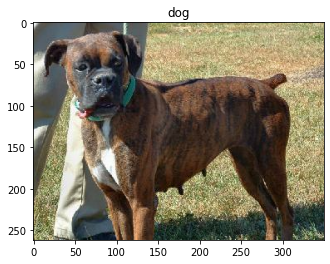

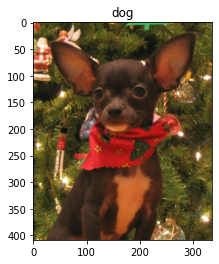

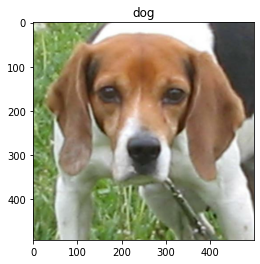

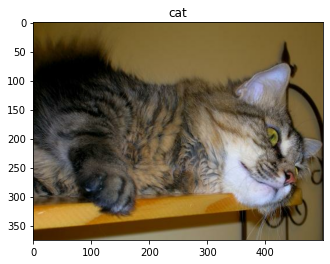

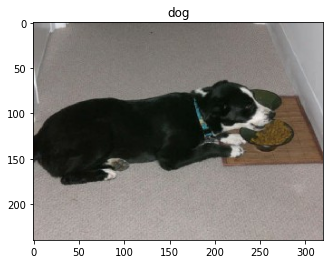

In [5]:
def plot_images(images, amount=5):
  get_label_name = metadata.features['label'].int2str
  for image, label in images.take(amount):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

plot_images(raw_train)

### Preprocessing of the images.
The images are made darker to increase the learning rate of the model.

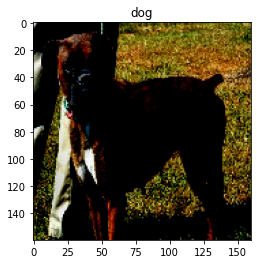

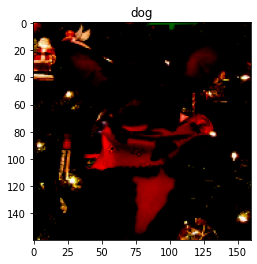

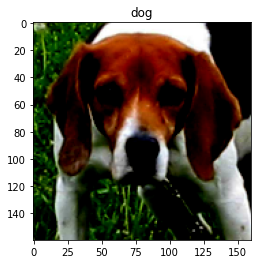

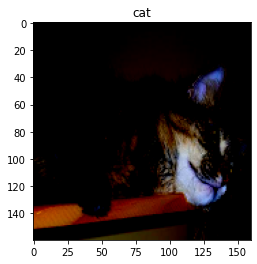

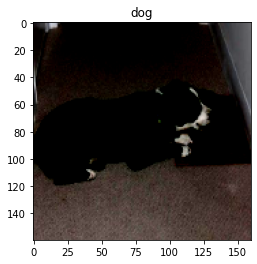

In [6]:
def pre_process_images(raw_train, raw_validation, raw_test):
  IMG_SIZE=160

  def format_example(image,label):
      image=tf.cast(image, tf.float32)
      image = (image/127.5) - 1
      image = tf.image.resize(image,(IMG_SIZE, IMG_SIZE))
      return image, label


  train= raw_train.map(format_example)
  validation= raw_validation.map(format_example)
  test= raw_test.map(format_example)

  plot_images(train)

  return train, validation, test

train, validation, test = pre_process_images(raw_train, raw_validation, raw_test)

### Shuffle the datasets and get the MobileNetV2 base model

In [7]:
def get_base_model():
  BATCH_SIZE=32
  SHUFFLE_BUFFER_SIZE=1000
  train_batches= train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
  validation_batches= validation.batch(BATCH_SIZE)
  test_batches= test.batch(BATCH_SIZE)
  IMG_SHAPE = (160, 160, 3)

  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
  base_model.trainable = False
  base_model.summary()

  return base_model, train_batches, validation_batches, test_batches

base_model, train_batches, validation_batches, test_batches = get_base_model()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
________________

### Add extra layers at the end which can be trained

In [8]:
def get_model(base_model):
  global_avg_layer= tf.keras.layers.GlobalAveragePooling2D()
  pred_layer=tf.keras.layers.Dense(1)
  model = tf.keras.Sequential([base_model, global_avg_layer, pred_layer])
  model.summary()

  return model

model = get_model(base_model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


### Train the model
Using a learning rate of 0.0001 with a RMSprop optimizer, a BinaryCrossentropy loss function since we are dealing with two options (binary).
The colde below is run **with** a GPU.

In [9]:
%%time
def train_model(model, train_batches, validation_batches):
  base_learn_rate = 0.0001

  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learn_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

  history= model.fit(train_batches, epochs=5 , validation_data=validation_batches)

  model.save(MODEL_FILE)

  return history, model

history, model = train_model(model, train_batches, validation_batches)


Epoch 1/5
582/582 [==============================] - 86s 88ms/step - loss: 0.3445 - accuracy: 0.8202 - val_loss: 0.0918 - val_accuracy: 0.9665
Epoch 2/5
582/582 [==============================] - 51s 86ms/step - loss: 0.0813 - accuracy: 0.9718 - val_loss: 0.0676 - val_accuracy: 0.9729
Epoch 3/5
582/582 [==============================] - 52s 87ms/step - loss: 0.0623 - accuracy: 0.9774 - val_loss: 0.0589 - val_accuracy: 0.9772
Epoch 4/5
582/582 [==============================] - 52s 86ms/step - loss: 0.0548 - accuracy: 0.9795 - val_loss: 0.0547 - val_accuracy: 0.9794
Epoch 5/5
582/582 [==============================] - 52s 87ms/step - loss: 0.0503 - accuracy: 0.9819 - val_loss: 0.0525 - val_accuracy: 0.9785
CPU times: user 5min 32s, sys: 21.6 s, total: 5min 54s
Wall time: 4min 53s


### Plot the loss and accuracy of the train and validation datasets

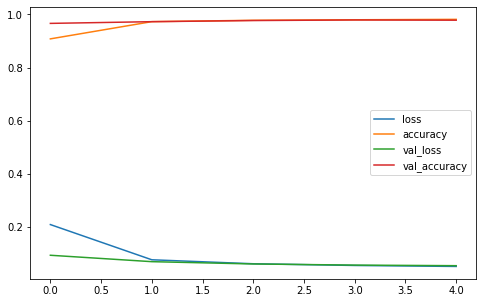

In [10]:
def plot_metrics(history):
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.savefig("loss_accuracy_model.png", )
  plt.show()

plot_metrics(history)

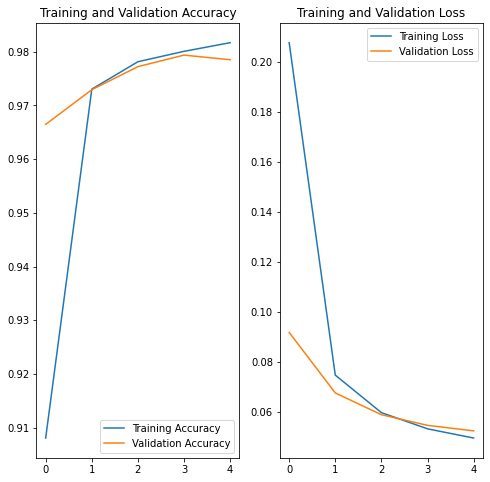

In [11]:
def plot_accuracies(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(5)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.savefig("loss_accuracy_model_separate.png")
  plt.show()
plot_accuracies(history)

### Load a saved model

In [ ]:
def load_model():
  return tf.keras.models.load_model(MODEL_FILE)

### Predict new images using the trainied model
Some of the predictions are plotted.

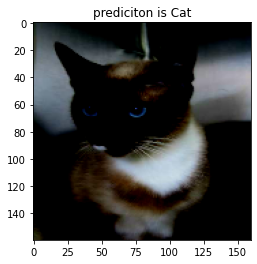

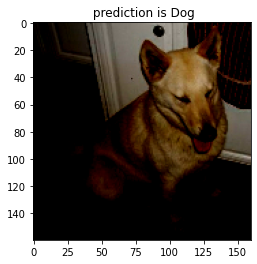

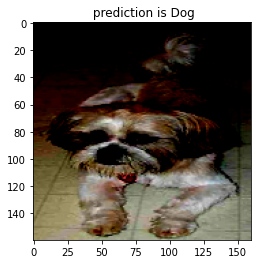

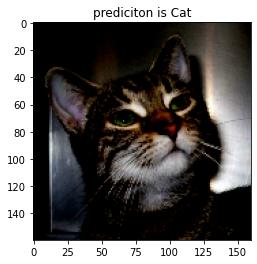

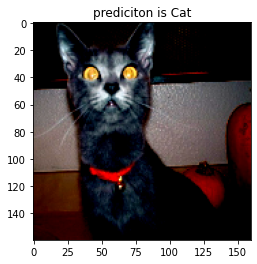

In [12]:
def predict(model, test, test_batches, amount=5):
  predictions= model.predict(test_batches)
  i=0
  for image, label in test.take(amount):
      plt.figure()
      plt.imshow(image)
      if predictions[i]>0:
          plt.title(" prediction is Dog")
      elif predictions[i]<0:
          plt.title("prediciton is Cat")
      i+=1
  return predictions

# model = load_model()
predictions = predict(model, test, test_batches, amount=5)


### Plot images which were wrongly classified

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


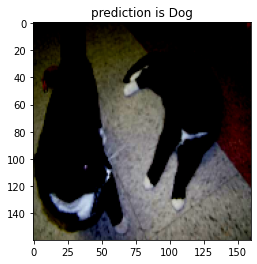

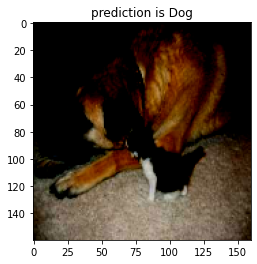

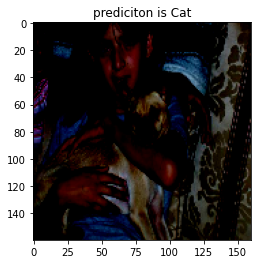

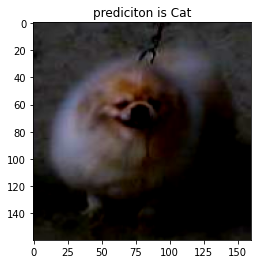

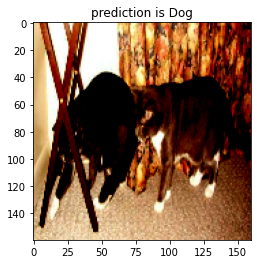

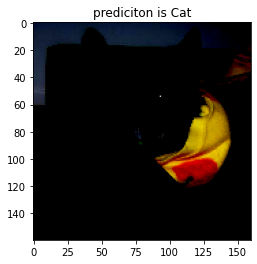

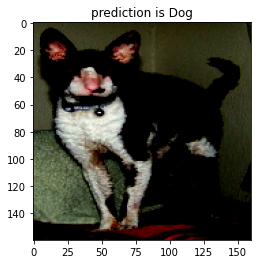

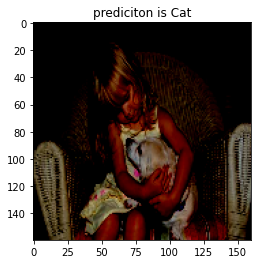

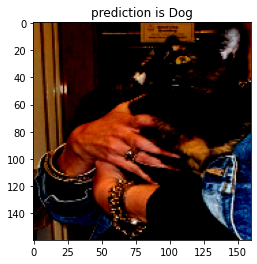

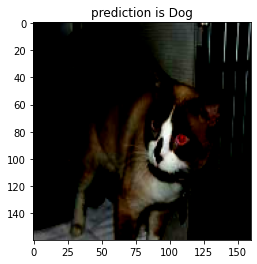

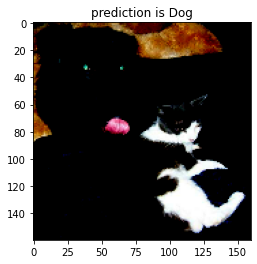

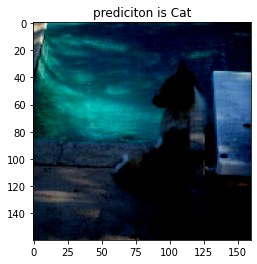

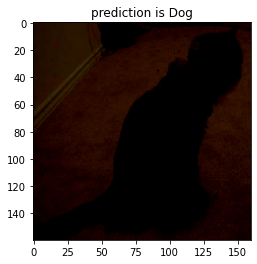

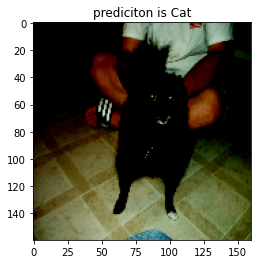

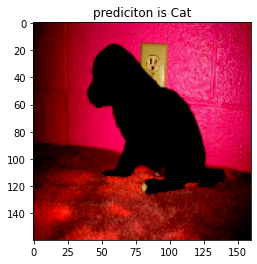

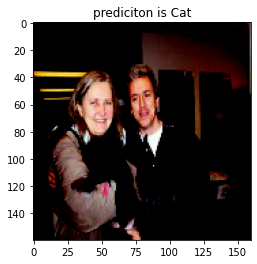

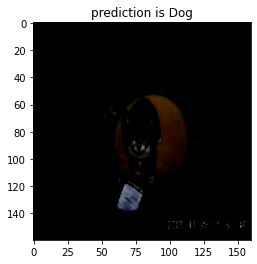

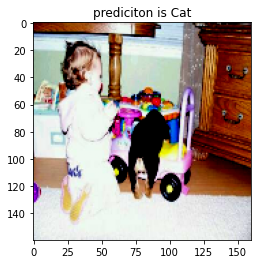

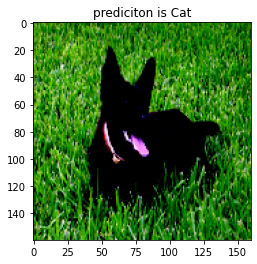

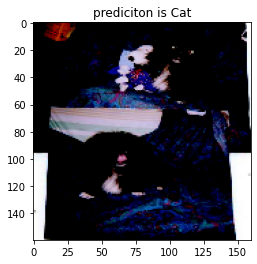

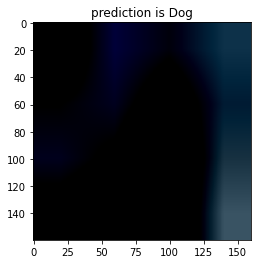

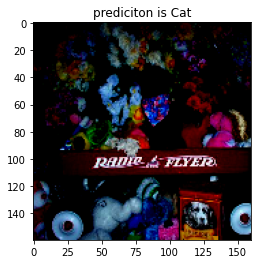

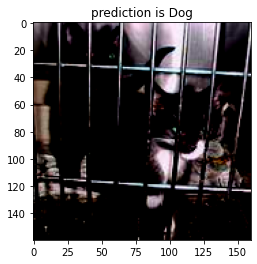

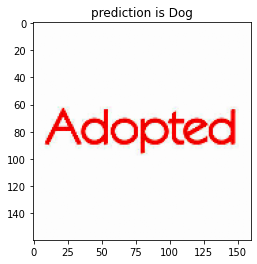

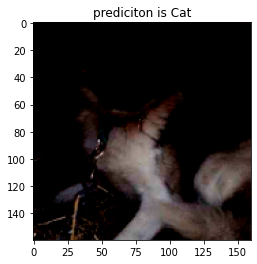

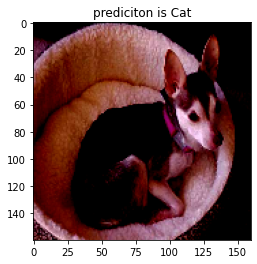

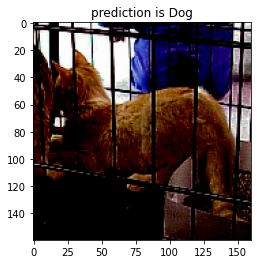

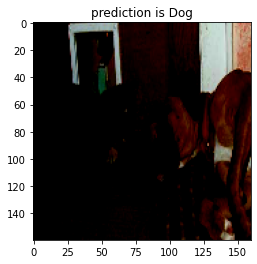

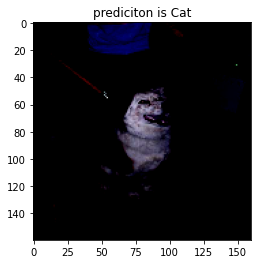

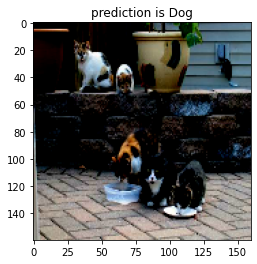

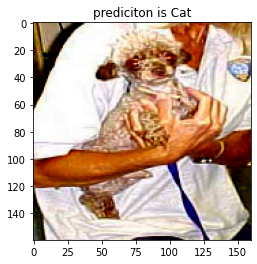

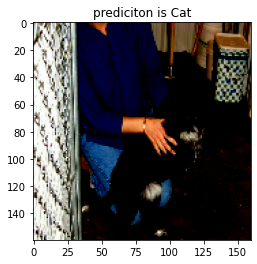

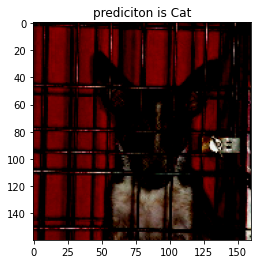

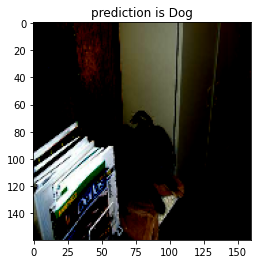

In [16]:
def plot_incorrect_images(test, predictions):
  images, labels = tuple(zip(*test))
  for i, (image, label) in enumerate(zip(images, np.array(labels))):
    prediction = 1 if predictions[i] > 0 else 0
    if prediction != label:
      plt.figure()
      plt.imshow(image)
      if prediction > 0:
          plt.title("prediction is Dog")
      else:
          plt.title("prediciton is Cat")
plot_incorrect_images(test, predictions)

### Cosnfusion matrix

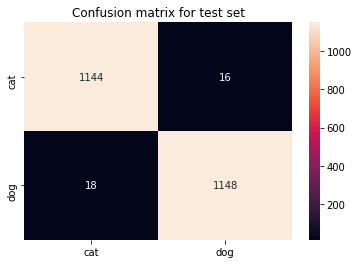

In [27]:
def plot_confusion_matrix(test):
  images, labels = tuple(zip(*test))
  conf_matrix = confusion_matrix(np.array(labels), [1 if x > 0 else 0 for x in predictions])
  sns.heatmap(conf_matrix, annot=True, cmap="rocket", fmt='d', xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
  plt.title("Confusion matrix for test set")
  plt.savefig("conf_matrix.png")
  plt.show()
plot_confusion_matrix(test)

### CPU information

In [17]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

### GPU information

In [18]:
!nvidia-smi

Tue Apr  6 08:18:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |   2880MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------